<table><tr>
<td><img src="logo/Adagos_Logo.png" alt="Drawing" style="width: 150px;"/></td>
    <td><img src="logo/logo_sirea.png" alt="Drawing" style="width: 200px;"/></td>
</tr></table>


# Lecture des données

Choisir la station à étudier entre Marceau Almaric, SYD TGBT1, SYD TGBT2, SYD TGBT3


In [21]:
%matplotlib notebook
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from build_neureco import *
from sirea_storage import *

bleu = '#01506B'
vert = '#36A99E'


from IPython.display import display, Markdown, clear_output
import ipywidgets as widgets
stat = widgets.Dropdown(
       options=['Marceau Almaric', 'SYD TGBT1', 'SYD TGBT2', 'SYD TGBT3'],
       value='Marceau Almaric',
       description='Station:')

cap = widgets.FloatSlider(
         value=50,
         min=0,
         max=100.0,
         step=10)
stat

Dropdown(description='Station:', options=('Marceau Almaric', 'SYD TGBT1', 'SYD TGBT2', 'SYD TGBT3'), value='Ma…

<IPython.core.display.Javascript object>


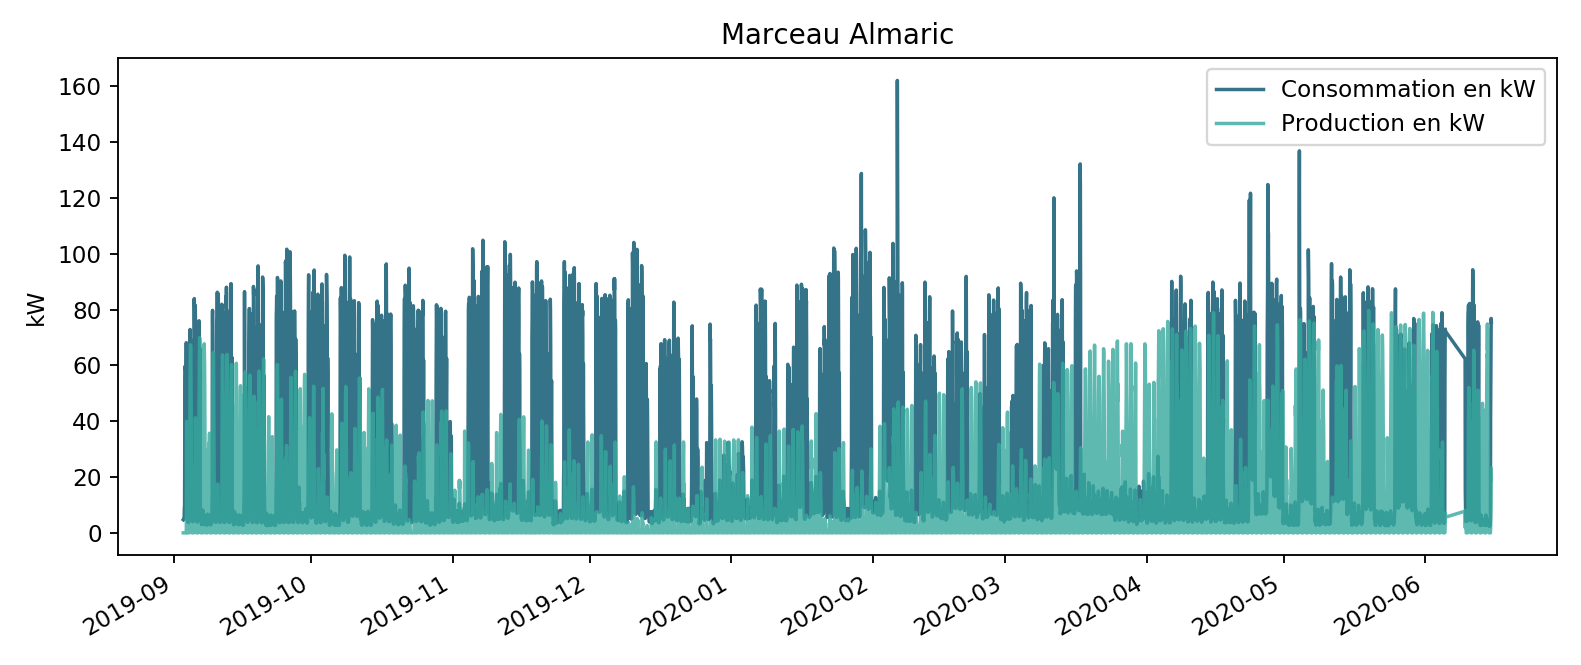

In [22]:
station = stat.value
d_read = data_reader(station, type = 'Sirea')
ax = d_read.full_data[['load_kW', 'prod_kW']].dropna().plot(figsize = (9.5,4), title = station, color = [bleu, vert], alpha = 0.8)
plt.legend(['Consommation en kW', 'Production en kW'])
ax.set_ylabel("kW")

plt.tight_layout()
plt.show()

# Auto-consommation

Tout ce qui est produit par les panneaux solaires est soit consommé soit perdu. <br>
Et s'il n'y a pas assez de production, la consommation nécessaire restante est achetée à EDF. 

<IPython.core.display.Javascript object>


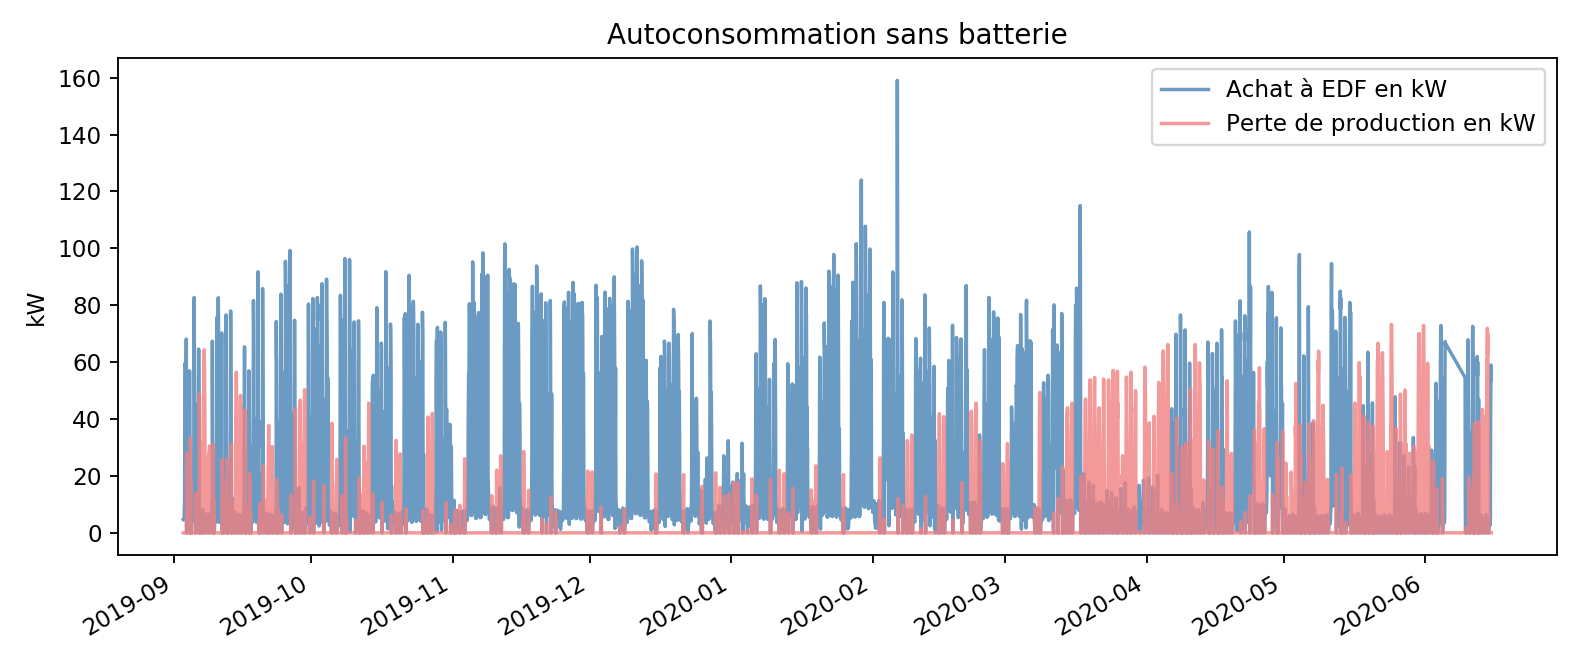

In [23]:
df = d_read.full_data
capacite= 0
storage = stockage(capacite, station)
storage.add_storage(d_read)
ax = storage.df[['import_kW', 'export_kW']].dropna().plot(figsize = (9.5,4), title = 'Autoconsommation sans batterie', color = ['steelblue', 'lightcoral'], alpha = 0.8)
plt.legend(['Achat à EDF en kW', 'Perte de production en kW'])
ax.set_ylabel("kW")

plt.tight_layout()
plt.show()

# Ajout batterie

Afin de diminuer les pertes de production, une batterie peut être installée. <br>
Les hypothèses sont les suivantes : <br>
- seuil max de charge = 98% de la capacite <br>
- seuil max de décharge = 20% de la capacite <br>
- puissance charge = puissance de l'armoire SIREA <br>
- puisance de décharge = 10% de la capacite <br>
                                                                               

In [25]:
from ipywidgets import IntSlider
from ipywidgets import HBox, Label

HBox([Label('Capacité en kWh : '), cap])

<IPython.core.display.Javascript object>


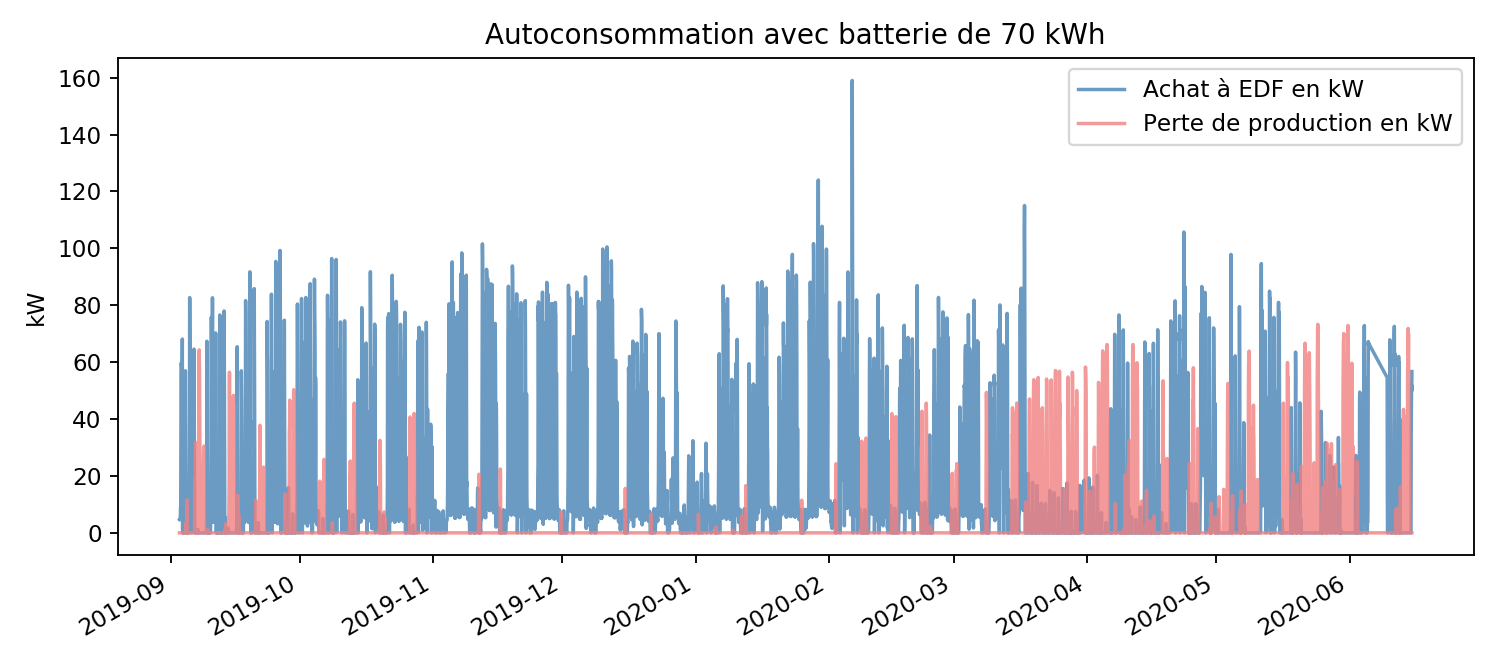

In [26]:
df = d_read.full_data
capacite= int(cap.value)
storage = stockage(capacite, station)
storage.add_storage(d_read)
ax = storage.df[['import_storage_kW', 'export_storage_kW']].dropna().plot(figsize = (9,4), title = 'Autoconsommation avec batterie de '+str(capacite)+ ' kWh', color = ['steelblue', 'lightcoral'], alpha = 0.8)
plt.legend(['Achat à EDF en kW', 'Perte de production en kW'])
ax.set_ylabel("kW")

plt.tight_layout()
plt.show()

# Dimensionnement optimal de la batterie

Afin de déterminer le dimensionnement optimal de la batterie pour chaque site, nous allons comparer le pourcentage d'autoconsommation au temps d'amortissement. <br>
Les hypothèses sont les suivantes : <br>
- prix de la batterie = 120€ du kWh <br>
- prix achat EDF = 0.1€ du kWh pour Marceau Almaric, 0.15€ du kWh pour les autres stations <br>




In [27]:
df = d_read.full_data
capacite= [0, 10,20,30,40,50,60,70,80,90,100]
results = pd.DataFrame()
for c in capacite:
    storage = stockage(c, station)
    results = results.append(storage.interet_stockage(d_read))
results = results.set_index('capacite')
results


,%_autoconsomation,%_pertes_prod,gain_E_par_an,annees_amortissement
capacite,,,,
0,30.037474,35.879817,0.000000,NaN
10,31.061819,33.689850,196.516576,6.106355
20,31.974058,31.739247,371.525924,6.459845
30,32.796504,29.980363,529.308959,6.801321
40,33.564666,28.337384,676.677860,7.093479
50,34.259565,26.850833,809.991393,7.407486
60,34.875342,25.533219,928.125732,7.757570
70,35.407144,24.394903,1030.149854,8.154153
80,35.868301,23.407424,1118.621133,8.581994


<IPython.core.display.Javascript object>


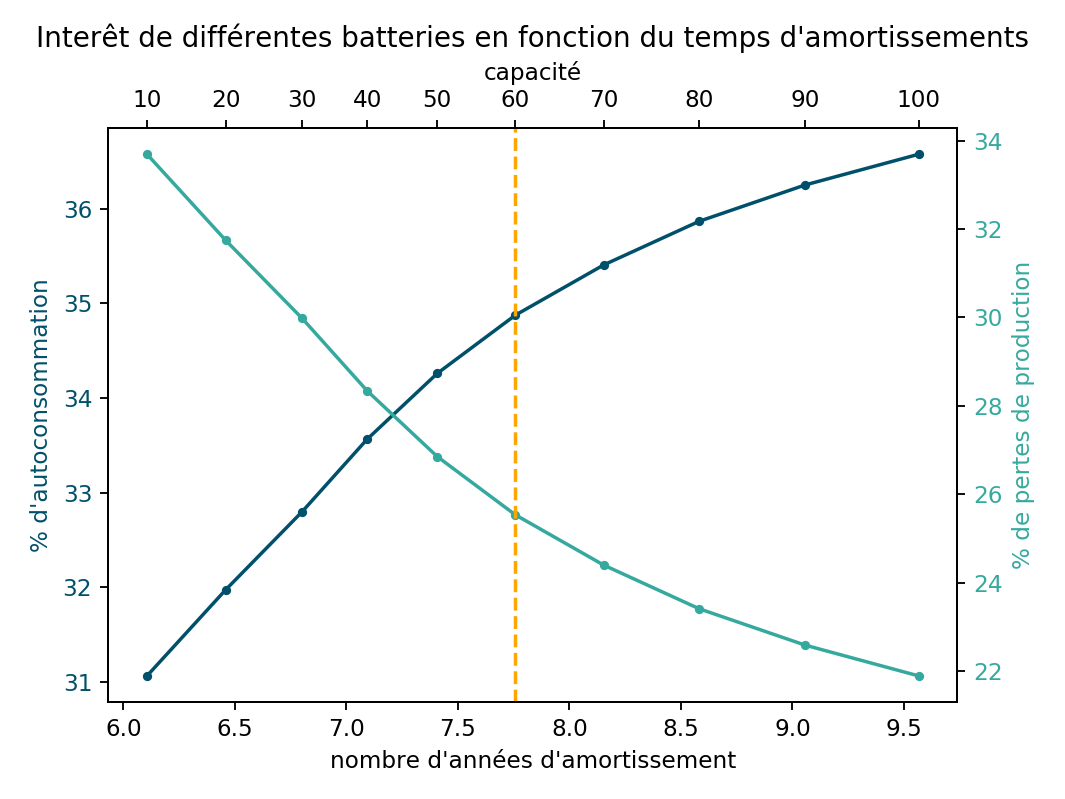

In [28]:
res = results.drop(results.index[0])

fig, ax1 = plt.subplots()
color = bleu
ax1.set_xlabel("nombre d'années d'amortissement")
ax1.set_ylabel("% d'autoconsommation", color=color)
ax1.plot(res.annees_amortissement, res['%_autoconsomation'], marker = '.', color = bleu)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx() 
color = vert
ax2.set_ylabel("% de pertes de production", color=color)  # we already handled the x-label with ax1
ax2.plot(res.annees_amortissement, res['%_pertes_prod'], marker = '.', color = vert)
ax2.tick_params(axis='y', labelcolor=color)

ax3 = ax1.twiny()
ax3.set_xlim(ax1.get_xlim())
ax3.set_xticks(res.annees_amortissement)
ax3.set_xticklabels(res.index)
ax3.set_xlabel("capacité")
ax3.axvline(x= res.loc[60,'annees_amortissement'], color = 'orange', linestyle = '--')
plt.title("Interêt de différentes batteries en fonction du temps d'amortissements")

plt.tight_layout()
plt.show()